# Инициализация

In [24]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, LSTM, Bidirectional, SpatialDropout1D, Flatten, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU, SimpleRNN
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
from tensorflow import keras
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# Максимальное количество слов
num_words = 10000
# Максимальная длина комментария
max_comment_len = 50
#Число классов
num_classes = 6

# Загрузка тренировочных данных

In [26]:
train = pd.read_csv('toxicCommentsDataSet/toxicCommentsTrain.csv')

In [27]:
#Получение комментариев
comments = train['comment_text']

In [28]:
y_train = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Токенизация

In [29]:
tokenizer = Tokenizer(num_words=num_words)

In [30]:
#Обучение токенайзера
tokenizer.fit_on_texts(comments)

In [31]:
train_sequences = tokenizer.texts_to_sequences(comments)

In [32]:
x_train = pad_sequences(train_sequences, maxlen=max_comment_len)

# Загрузка тестовых данных

In [33]:
test_comments = pd.read_csv('toxicCommentsDataSet/toxicCommentsTest.csv')

In [34]:
test_labels = pd.read_csv('toxicCommentsDataSet/toxicCommentsTestLabels.csv')

In [35]:
test_full = pd.merge(test_comments, test_labels, on='id')

In [36]:
test = test_full[test_full['toxic']!=-1]

# Токенизация

In [37]:
test_sequences = tokenizer.texts_to_sequences(test['comment_text'])

In [38]:
y_test = test[['toxic',	'severe_toxic',	'obscene', 'threat',	'insult',	'identity_hate']]

In [39]:
x_test = pad_sequences(test_sequences, maxlen=max_comment_len)

# Проверка лучшей модели

In [40]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=116, input_length=max_comment_len,
                    embeddings_regularizer=keras.regularizers.l2(0.001)))
model.add(LSTM(units=28, activation='selu', kernel_regularizer=keras.regularizers.l2(0.001), return_sequences=True))
model.add(LSTM(units=28, activation='selu', kernel_regularizer=keras.regularizers.l2(0.001), return_sequences=True))
model.add(LSTM(units=28, activation='selu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[keras.metrics.AUC(name="auc"), "accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 116)           1160000   
                                                                 
 lstm_2 (LSTM)               (None, 50, 28)            16240     
                                                                 
 lstm_3 (LSTM)               (None, 50, 28)            6384      
                                                                 
 lstm_4 (LSTM)               (None, 28)                6384      
                                                                 
 dense_1 (Dense)             (None, 6)                 174       
                                                                 
Total params: 1,189,182
Trainable params: 1,189,182
Non-trainable params: 0
_________________________________________________________________


In [41]:
history_model = model.fit(x_train,
                          y_train,
                          epochs=5,
                          batch_size=1024,
                          validation_split=0.2)

Epoch 1/5
125/125 [==============================] - 168s 1s/step - loss: 0.3197 - auc: 0.8371 - accuracy: 0.9510 - val_loss: 0.1526 - val_auc: 0.9347 - val_accuracy: 0.9759
Epoch 2/5
125/125 [==============================] - 143s 1s/step - loss: 0.1259 - auc: 0.9395 - accuracy: 0.9814 - val_loss: 0.1010 - val_auc: 0.9570 - val_accuracy: 0.9838
Epoch 3/5
125/125 [==============================] - 134s 1s/step - loss: 0.1024 - auc: 0.9505 - accuracy: 0.9824 - val_loss: 0.1086 - val_auc: 0.9638 - val_accuracy: 0.9785
Epoch 4/5
125/125 [==============================] - 130s 1s/step - loss: 0.0905 - auc: 0.9560 - accuracy: 0.9754 - val_loss: 0.0824 - val_auc: 0.9644 - val_accuracy: 0.9795
Epoch 5/5
125/125 [==============================] - 138s 1s/step - loss: 0.0837 - auc: 0.9597 - accuracy: 0.9750 - val_loss: 0.0825 - val_auc: 0.9691 - val_accuracy: 0.9894


In [42]:
model.evaluate(x_test, y_test)

2000/2000 [==============================] - 39s 19ms/step - loss: 0.1059 - auc: 0.9591 - accuracy: 0.9852


[0.10594627261161804, 0.9591419100761414, 0.9852449297904968]

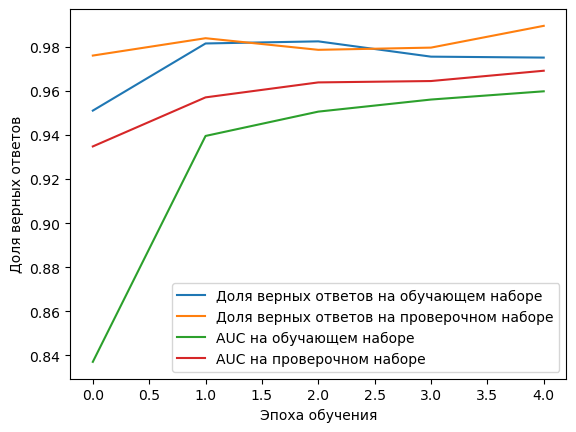

In [43]:
plt.plot(history_model.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_model.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.plot(history_model.history['auc'],
         label='AUC на обучающем наборе')
plt.plot(history_model.history['val_auc'],
         label='AUC на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()